In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
DATA_DIR = "/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA"

In [4]:
classes = sorted(os.listdir(DATA_DIR))
num_classes = len(classes)


In [5]:
print("number of classes = ",num_classes)
print("Classes:", classes)

number of classes =  58
Classes: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '6', '7', '8', '9']


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


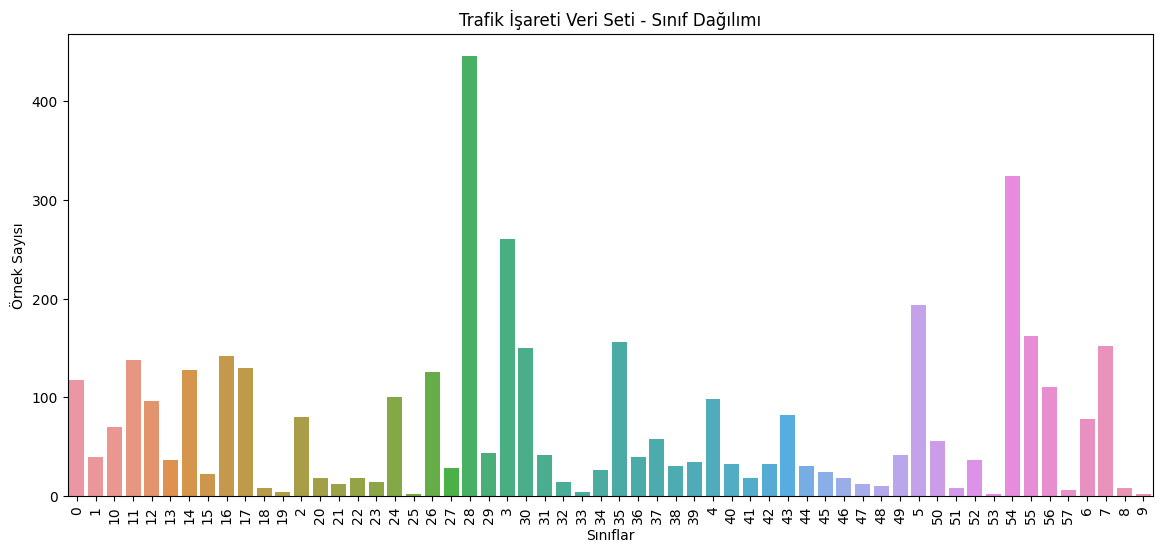

In [6]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Sınıf dağılımını say
class_counts = {cls: len(os.listdir(os.path.join(DATA_DIR, cls))) for cls in classes}

# Bar grafiği çiz
plt.figure(figsize=(14, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.xlabel("Sınıflar")
plt.ylabel("Örnek Sayısı")
plt.title("Trafik İşareti Veri Seti - Sınıf Dağılımı")
plt.show()

In [7]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

In [8]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [9]:
class TrafficSignDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for label, class_name in enumerate(sorted(os.listdir(data_dir))):
            class_path = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
dataset = TrafficSignDataset(DATA_DIR, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Eğitim örnekleri: {len(train_dataset)}")
print(f"Test örnekleri: {len(test_dataset)}")

Eğitim örnekleri: 3336
Test örnekleri: 834


In [11]:
import torch.nn as nn
import torch.optim as optim

#  CNN Modeli
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=58):
        super(TrafficSignCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))

        x = torch.flatten(x, start_dim=1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Modeli Başlat
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficSignCNN().to(device)

# Loss ve Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 20

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total

    # Her 5 epoch'ta bir göster
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs} - Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

Epoch 1/20 - Loss: 2.9921, Accuracy: 22.21%
Epoch 5/20 - Loss: 0.2598, Accuracy: 91.76%
Epoch 10/20 - Loss: 0.0314, Accuracy: 99.16%
Epoch 15/20 - Loss: 0.0245, Accuracy: 99.40%
Epoch 20/20 - Loss: 0.0667, Accuracy: 98.11%


In [13]:

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 98.80%
